# Comparing M&M with MT-HESS

MT-HESS does not give credible sets. Herein we compare the marginal PIP in terms of calibration and precision-recall curves.

In [1]:
%cd /home/gaow/GIT/github/mnm-twas/dsc/mthess

/home/gaow/Documents/GIT/github/mnm-twas/dsc/mthess

In [2]:
[global]
parameter: cwd = path('/home/gaow/GIT/github/mnm-twas/dsc')
parameter: data_dir = 'mthess'
parameter: date = '0228'
def fmtP(x):
    return str(x).replace(".", "p")

## PIP extraction

In [3]:
# Extract meta info
[pip_1,roc_1]
output: f'{cwd}/{data_dir}/PIP_comparison_{date}.pips_meta.rds'
R: expand = '${ }', workdir = cwd
    data = dscrutils::dscquery('mthess', target = "small_data.dataset high_het methods methods.DSC_TIME", group = c("methods: mnm_high_het mnm_mixture01 mthess", "mnm:"), ignore.missing.file=T)
    data = data[which(!is.na(data$small_data.dataset)),]
    saveRDS(data, ${_output:r})

In [ ]:
# Extract PIP
[pip_2,roc_2]
output: f'{cwd}/{data_dir}/PIP_comparison_{date}.pips_data.rds'
R: expand = '${ }', workdir = f'{cwd}/{data_dir}'
  meta = readRDS(${_input:r})
  # remove bad files
  bad_files = vector()
  for (f in meta$methods.output.file) {
      if (!file.exists(paste0(f,'.rds'))) bad_files = append(bad_files, f)
  }
  meta = meta[which(!(meta$methods.output.file %in% bad_files)),]
  # now collect matrices for each method, of two columns: pip and true_coef
  res = list()
  for (i in 1:nrow(meta)) {
      true_coef = as.integer(dscrutils:::read_dsc(paste0(meta[i,3], '.pkl'))$meta$true_coef != 0)
      # make it a vector
      true_coef = c(true_coef)
      method = meta[i,4]
      if (method == "mthess") {
          pip = dscrutils:::read_dsc(paste0(meta[i,5], '.rds'))$result$pip_conditions
      } else {
          res = dscrutils:::read_dsc(paste0(meta[i,5], '.rds'))$result
          pip = mmbr::mmbr_get_pip_per_condition(res, res$m_init)
      }
      # PIP is matrix of P (SNPs) by R (conditions); now make it a vector
      pip = c(pip)
      if (!(method %in% names(res))) {
        res[[method]] = list(pip = pip, truth = true_coef)
      } else {
        res[[method]]$pip = append(res[[method]]$pip, pip)
        res[[method]]$truth = append(res[[method]]$truth, true_coef)
      }
  }
  for (method in unique(meta$methods)) {
      res[[method]] = do.call(cbind, res[[method]])
  }
  saveRDS(res, ${_output:r})

The output looks like:

```
> names(dat)
[1] "mnm_high_het"  "mnm_mixture01" "mthess"       
> head(dat$mthess)
           pip truth
V1 0.018042142     0
V2 0.014788800     0
V3 0.006386173     0
V4 0.007783144     0
V5 0.000999730     0
```

Next we need to evaluate the calibration and ROC of pips.

## PIP calibration

In [ ]:
# Calibration and ROC data
[pip_3]
parameter: bin_size = 20
output: f'{_input:nn}.pip_evaluation.rds'
R: expand = '${ }', workdir = cwd
  dat = readRDS(${_input:r})
  bins = cbind(seq(1:${bin_size})/${bin_size}-1/${bin_size}, seq(1:${bin_size})/${bin_size})
  pip_cali = list()
  for (method in names(dat)) {
      pip_cali[[method]] = matrix(NA, nrow(bins), 3)
      for (i in 1:nrow(bins)) {
        data_in_bin = dat[[method]][which(dat[[method]][,1] > bins[i,1] & dat[[method]][,1] < bins[i,2]),]
        pip_cali[[method]][i,1] = sum(data_in_bin[,1])
        pip_cali[[method]][i,2] = sum(data_in_bin[,2])
        pip_cali[[method]][i,3] = nrow(data_in_bin)
      }
  }
  for (method in names(dat)) {
      pip_cali[[method]][,c(1,2)] = pip_cali[[method]][,c(1,2)] / pip_cali[[method]][,3]
  }
  saveRDS(pip_cali, ${_output:r})

In [ ]:
# Calibration plot
[pip_4]
output: f'{_input:nn}.pip_evaluation.png'
R: expand = '${ }', workdir = cwd
    library(ggplot2)
    library(cowplot)
    dot_plot = function(dataframe) {
        ggplot(dataframe, aes(x=mean_pip, y=observed_freq)) + 
          geom_errorbar(aes(ymin=observed_freq-se, ymax=observed_freq+se), colour="gray", size = 0.2, width=.01) +
          geom_point(size=1.5, shape=21, fill="#002b36") + # 21 is filled circle
          xlab("Mean PIP") +
          ylab("Observed frequency") +
          coord_cartesian(ylim=c(0,1), xlim=c(0,1)) +
          geom_abline(slope=1,intercept=0,colour='red', size=0.2) +
          ggtitle(name) +
          expand_limits(y=0) +                        # Expand y range
          theme_cowplot()
    }
    dat = readRDS(${_input:r})
    idx = 0
    for (name in names(dat)) {
      idx = idx + 1
      dat[[name]][,3] = sqrt(dat[[name]][,2] * (1 - dat[[name]][,2]) / dat[[name]][,3]) * 2
      dat[[name]] = as.data.frame(dat[[name]])
      colnames(dat[[name]]) = c("mean_pip", "observed_freq", "se")
      pdf(paste0(${_output:nr}, '_' , idx, '.pdf'), width=3, height=3, pointsize=16)
          print(dot_plot(dat[[name]]))
      dev.off()
      system(paste0("convert -density 120 ", ${_output:nr}, '_' , idx, '.pdf', " ", ${_output:nr}, '_' , idx, '.png'))
    }
    files = paste0(${_output:nr}, '_', seq(1:idx), '.png')
    cmd = paste('convert +append', paste(files, collapse=" "), ${_output:r})
    system(cmd)
    system(paste('rm -f', paste(files, collapse=" ")))

`M&M` calibration is okay; but not so much for `mthess` -- mean PIP tends to be greater than the truth. Should we plot it backwards?

> /home/gaow/GIT/github/mnm-twas/dsc/mthess/PIP_comparison_0228.pip_evaluation.png (34.3 KiB):

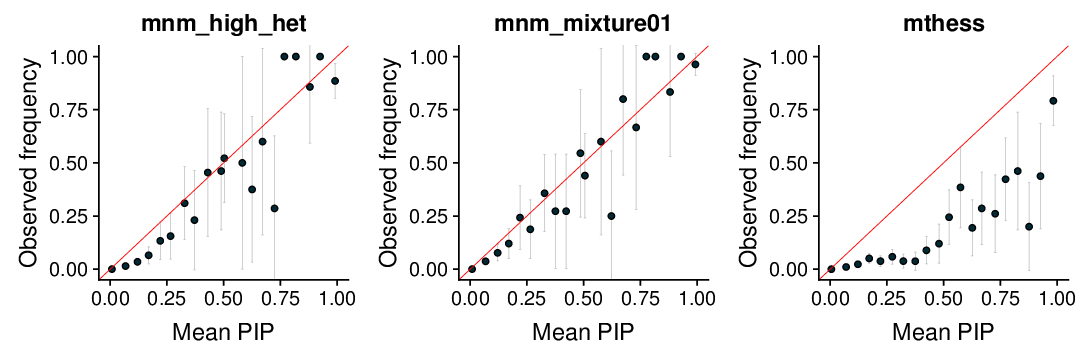

In [17]:
%preview /home/gaow/GIT/github/mnm-twas/dsc/mthess/PIP_comparison_0228.pip_evaluation.png

## ROC

In [ ]:
# Data for ROC
[roc_3]
pip_cutoff = 0.05
output: f'{_input:nn}.roc.rds'
R: expand = '${ }', workdir = cwd
    roc_data = function(d1, cutoff = c(${pip_cutoff}, 0.995), connect_org = TRUE) {
        grid = 2000
        ttv = seq(1:grid)/grid
        ttv = ttv[which(ttv>=cutoff[1] & ttv<=cutoff[2])]
        # see SuSiE-Manuscript issue 2
        d1 = d1[order(d1[,1]), ]
        end = tail(d1[which(d1[,2] == 0),][,1],1)
        ttv = c(ttv[-length(ttv)], min(ttv[length(ttv)], end))
        # end of issue 2
        rst1 = t(sapply(ttv, function(x) c(sum(d1[,2][d1[,1]>=x]), length(d1[,2][d1[,1]>=x]))))
        rst1 = cbind(rst1, sum(d1[,2]))
        if (connect_org) {
            # connect to origin
            last_row = tail(rst1, 1)
            rst1 = rbind(rst1, c(last_row[1], last_row[2]-1, last_row[3]), c(0.001,0.001,last_row[3]))
        }
        rst1 = as.data.frame(rst1)
        colnames(rst1) = c('true_positive', 'total_positive', 'total_signal')
        if (connect_org) {
            rst2 = as.data.frame(cbind(rst1$true_positive / rst1$total_positive, rst1$true_positive / rst1$total_signal,  c(ttv, ttv[length(ttv)], 1)))
        } else {
            rst2 = as.data.frame(cbind(rst1$true_positive / rst1$total_positive, rst1$true_positive / rst1$total_signal,  ttv))
        }
        colnames(rst2) = c('Precision', 'Recall', 'Threshold')
        return(list(counts = rst1, rates = rst2))
    }

    print("Computing ROC data ...")
    roc = list()
    dat = readRDS(${_input:r})
    for (method in names(dat)) {
      roc[[method]] = roc_data(dat[[method]])
    }
    saveRDS(roc, ${_output:r})

In [ ]:
# Plot for ROC
[roc_4]
parameter: chunks = 0
parameter: smooth = 'FALSE'
parameter: opt = "lwd = 2, xlim = c(0,0.5), ylim = c(0,0.5)"
parameter: main = "ROC"
output: f'{_input:nn}.roc.pdf'
R: expand = '${ }'
    colors = c('#A60628', '#7A68A6', '#348ABD', '#467821', '#FF0000', '#188487', '#E2A233',
                  '#A9A9A9', '#000000', '#FF00FF', '#FFD700', '#ADFF2F', '#00FFFF')
    dat = readRDS(${_input:r})
    library(scam)
    create_chunks = function(item, n) {
      splitted = suppressWarnings(split(item, 1:n))
      return(c(splitted[[1]], splitted[[length(splitted)]][length(splitted[[length(splitted)]])]))
    }
    make_smooth = function(x,y,subset=${chunks}, smooth = ${smooth}) {
      if (smooth) {
          if (subset < length(x) && subset > 0) {
              x = create_chunks(x, subset)
              y = create_chunks(y, subset)
          }
          dat = data.frame(cbind(x,y))
          colnames(dat) = c('x','y')
          y=predict(scam(y ~ s(x, bs = "mpi"), data = dat))
      }
      return(list(x=x,y=y))
    }
    add_text = function(thresholds, x, y, threshold, color, delta = 0.015) {
        idx = which(thresholds == threshold)
        text(x[idx] - delta, y[idx], labels = threshold, col = color)
        points(x[idx],y[idx])
    }
    rename = list(mnm_high_het = 'M&M (oracle)', mnm_mixture01 = 'M&M (default)', mthess = 'MT-HESS (default)')
    labels = vector()
    pdf(${_output:r}, width=5, height=5, pointsize=15)
    i = 1
    for (method in names(dat)) {
        yy = make_smooth(1 - dat[[method]]$rates$Precision, dat[[method]]$rates$Recall)
        if (i == 1) {
            plot(yy$x, yy$y, t="l", col=colors[i], ylab = "power", xlab ="FDR", main = "${main}", bty='l', ${opt})
        } else {
            lines(yy$x, yy$y, col=colors[i], ${opt})
        }
        #add_text(dat[[method]]$rates$Threshold, yy$x, yy$y, 0.9, colors[i])
        #add_text(dat[[method]]$rates$Threshold, yy$x, yy$y, 0.95, colors[i])
        labels[i] = rename[[method]]
        i = i + 1
    }
    legend("bottomright", legend=labels, col=colors[1:i], lty=c(1,1,1), cex=0.8)
    dev.off()

> /home/gaow/GIT/github/mnm-twas/dsc/mthess/PIP_comparison_0228.roc.pdf (8.8 KiB):

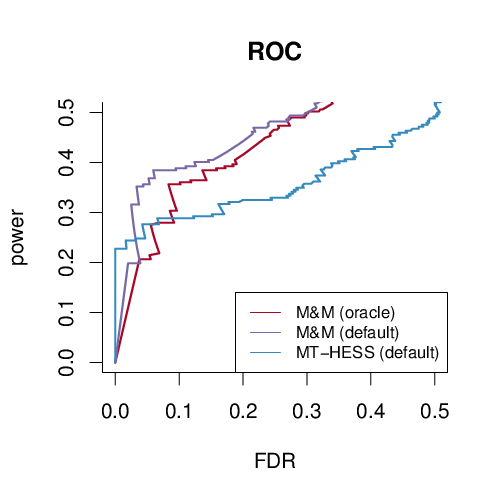

In [16]:
%preview /home/gaow/GIT/github/mnm-twas/dsc/mthess/PIP_comparison_0228.roc.pdf -s png --dpi 100

## Run time comparison

In [12]:
dat = readRDS('PIP_comparison_0228.pips_meta.rds')
dat = dat[,c(4,6)]
colnames(dat) = c('method', 'time')

In [14]:
aggregate(time~method,dat,mean)

method,time
mnm_high_het,9.49588
mnm_mixture01,34.17489
mthess,809.92551


In [15]:
aggregate(time~method,dat,median)

method,time
mnm_high_het,8.6225
mnm_mixture01,31.5915
mthess,375.3100


In [10]:
library(ggplot2)
library(cowplot)
# Basic violin plot
png('PIP_comparison_0228.runtime.png', 600, 600)
p = ggplot(dat, aes(x=method, y=time)) + 
  geom_violin(trim=FALSE, fill="gray")+
  labs(title="",x="method", y = "time elapsed (seconds)")+
  geom_boxplot(width=0.1)+
  theme_cowplot()
print(p)
dev.off()


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”

png 
  2

> PIP_comparison_0228.runtime.png (12.6 KiB):

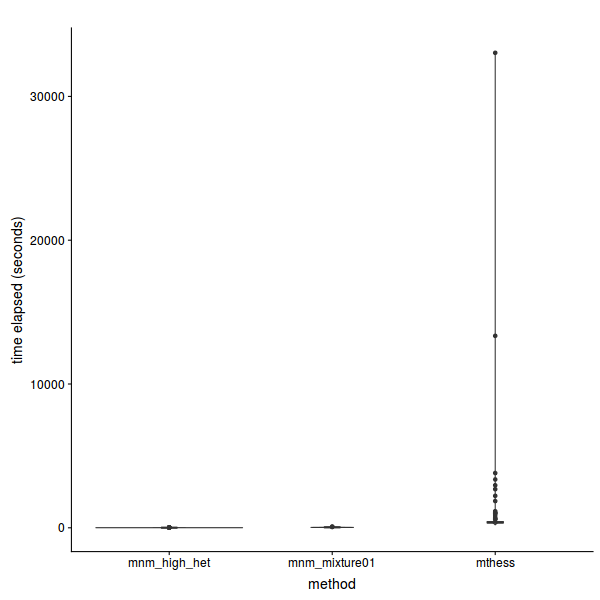

In [11]:
%preview PIP_comparison_0228.runtime.png